In [1]:
dataset = "P-SET"
llm_type = "llama3.1:70b"


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrices_for_column_pairs(df, gt_col,vis_columns):

    n_pairs = len(vis_columns)

    # Determine layout: square-ish grid
    n_cols = int(np.ceil(np.sqrt(n_pairs)))
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    col1 = gt_col
    for idx, col2 in enumerate(vis_columns):
        ax = axes[idx]
        
        # Drop rows with missing values in either column
        sub_df = df[[col1, col2]].dropna().copy()
        start_length = len(sub_df)
        # sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        filter_length = len(sub_df)
        # Get confusion matrix
        labels = sorted(set(sub_df[col1]) | set(sub_df[col2]))
        cm = confusion_matrix(sub_df[col1], sub_df[col2], labels=labels)

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"{col1} vs \n{col2}\n strt: {start_length}\nelim.:{filter_length-start_length}", fontsize=10)
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)

    # Hide any extra axes
    for j in range(len(vis_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    return fig


********************Sleep************************
Sleep_10_210_4783_164_att_True
Ao True Sleep_10_210_4783_164_att_True


is_keyword_present
0.0    271
1.0     29
Name: count, dtype: int64

GT_Sleep  is_keyword_present
False     0.0                   271
          1.0                    26
True      1.0                     3
Name: count, dtype: int64
file written to ../exports/disagreements/Sleep/all_correct_Sleep_10_210_4783_164_att_True.xlsx


,col_name,technique,pos_sup,neg_sup,f1_score,precision,recall,TP,TN,FP,FN,time
0,Event_Name_Sleep,Sleep_Ao,3,13,0.857143,0.750000,1.0,3,12,1,0,0.002219
1,Event_Name_LLM_Events_all_evidence_sentence_Sleep,LLM_KiEi__Ao_Sent-SET,3,13,0.500000,0.333333,1.0,3,7,6,0,1.694081
2,Event_Name_LLM_Events_all_evidence_document_Sleep,LLM_KiEi__Ao_Doc-SET,3,13,0.750000,0.600000,1.0,3,11,2,0,4.446695
3,Event_Name_LLM_Events_keyword_evidence_sentenc...,LLM__Ki__Ao_Sent-SET,3,13,0.500000,0.333333,1.0,3,7,6,0,1.713361
4,Event_Name_LLM_Events_keyword_evidence_documen...,LLM__Ki__Ao_Doc-SET,3,13,0.750000,0.600000,1.0,3,11,2,0,4.444325
5,Event_Name_LLM_Events_example_evidence_sentenc...,LLM__Ei__Ao_Sent-SET,3,13,0.545455,0.375000,1.0,3,8,5,0,1.676138
6,Event_Name_LLM_Events_example_evidence_documen...,LLM__Ei__Ao_Doc-SET,3,13,0.750000,0.600000,1.0,3,11,2,0,4.497877
7,Event_Name_LLM_Events_no_evidence_sentence_Sleep,LLM___Ao_Sent-SET,3,13,0.545455,0.375000,1.0,3,8,5,0,1.676563
8,Event_Name_LLM_Events_no_evidence_document_Sleep,LLM___Ao_Doc-SET,3,13,0.750000,0.600000,1.0,3,11,2,0,4.496963


Sleep_10_210_4783_164_att_False
 False Sleep_10_210_4783_164_att_False


is_keyword_present
0.0    271
1.0     29
Name: count, dtype: int64

GT_Sleep  is_keyword_present
False     0.0                   271
          1.0                    26
True      1.0                     3
Name: count, dtype: int64
file written to ../exports/disagreements/Sleep/all_correct_Sleep_10_210_4783_164_att_False.xlsx


,col_name,technique,pos_sup,neg_sup,f1_score,precision,recall,TP,TN,FP,FN,time
0,Event_Name_Sleep,Sleep_,3,13,0.857143,0.75,1.0,3,12,1,0,0.002219
1,Event_Name_LLM_Events_all_evidence_sentence_Sleep,LLM_KiEi___Sent-SET,3,13,0.666667,0.50,1.0,3,10,3,0,1.118216
2,Event_Name_LLM_Events_all_evidence_document_Sleep,LLM_KiEi___Doc-SET,3,13,1.000000,1.00,1.0,3,13,0,0,1.964349
3,Event_Name_LLM_Events_keyword_evidence_sentenc...,LLM__Ki___Sent-SET,3,13,0.666667,0.50,1.0,3,10,3,0,1.119180
4,Event_Name_LLM_Events_keyword_evidence_documen...,LLM__Ki___Doc-SET,3,13,1.000000,1.00,1.0,3,13,0,0,1.965565
5,Event_Name_LLM_Events_example_evidence_sentenc...,LLM__Ei___Sent-SET,3,13,0.666667,0.50,1.0,3,10,3,0,1.097680
6,Event_Name_LLM_Events_example_evidence_documen...,LLM__Ei___Doc-SET,3,13,1.000000,1.00,1.0,3,13,0,0,1.899741
7,Event_Name_LLM_Events_no_evidence_sentence_Sleep,LLM____Sent-SET,3,13,0.666667,0.50,1.0,3,10,3,0,1.097616
8,Event_Name_LLM_Events_no_evidence_document_Sleep,LLM____Doc-SET,3,13,1.000000,1.00,1.0,3,13,0,0,1.904490


********************Excretion************************
No ground truth file found for Excretion in ../exports/04_groundtruth/P-SET/Annotated/


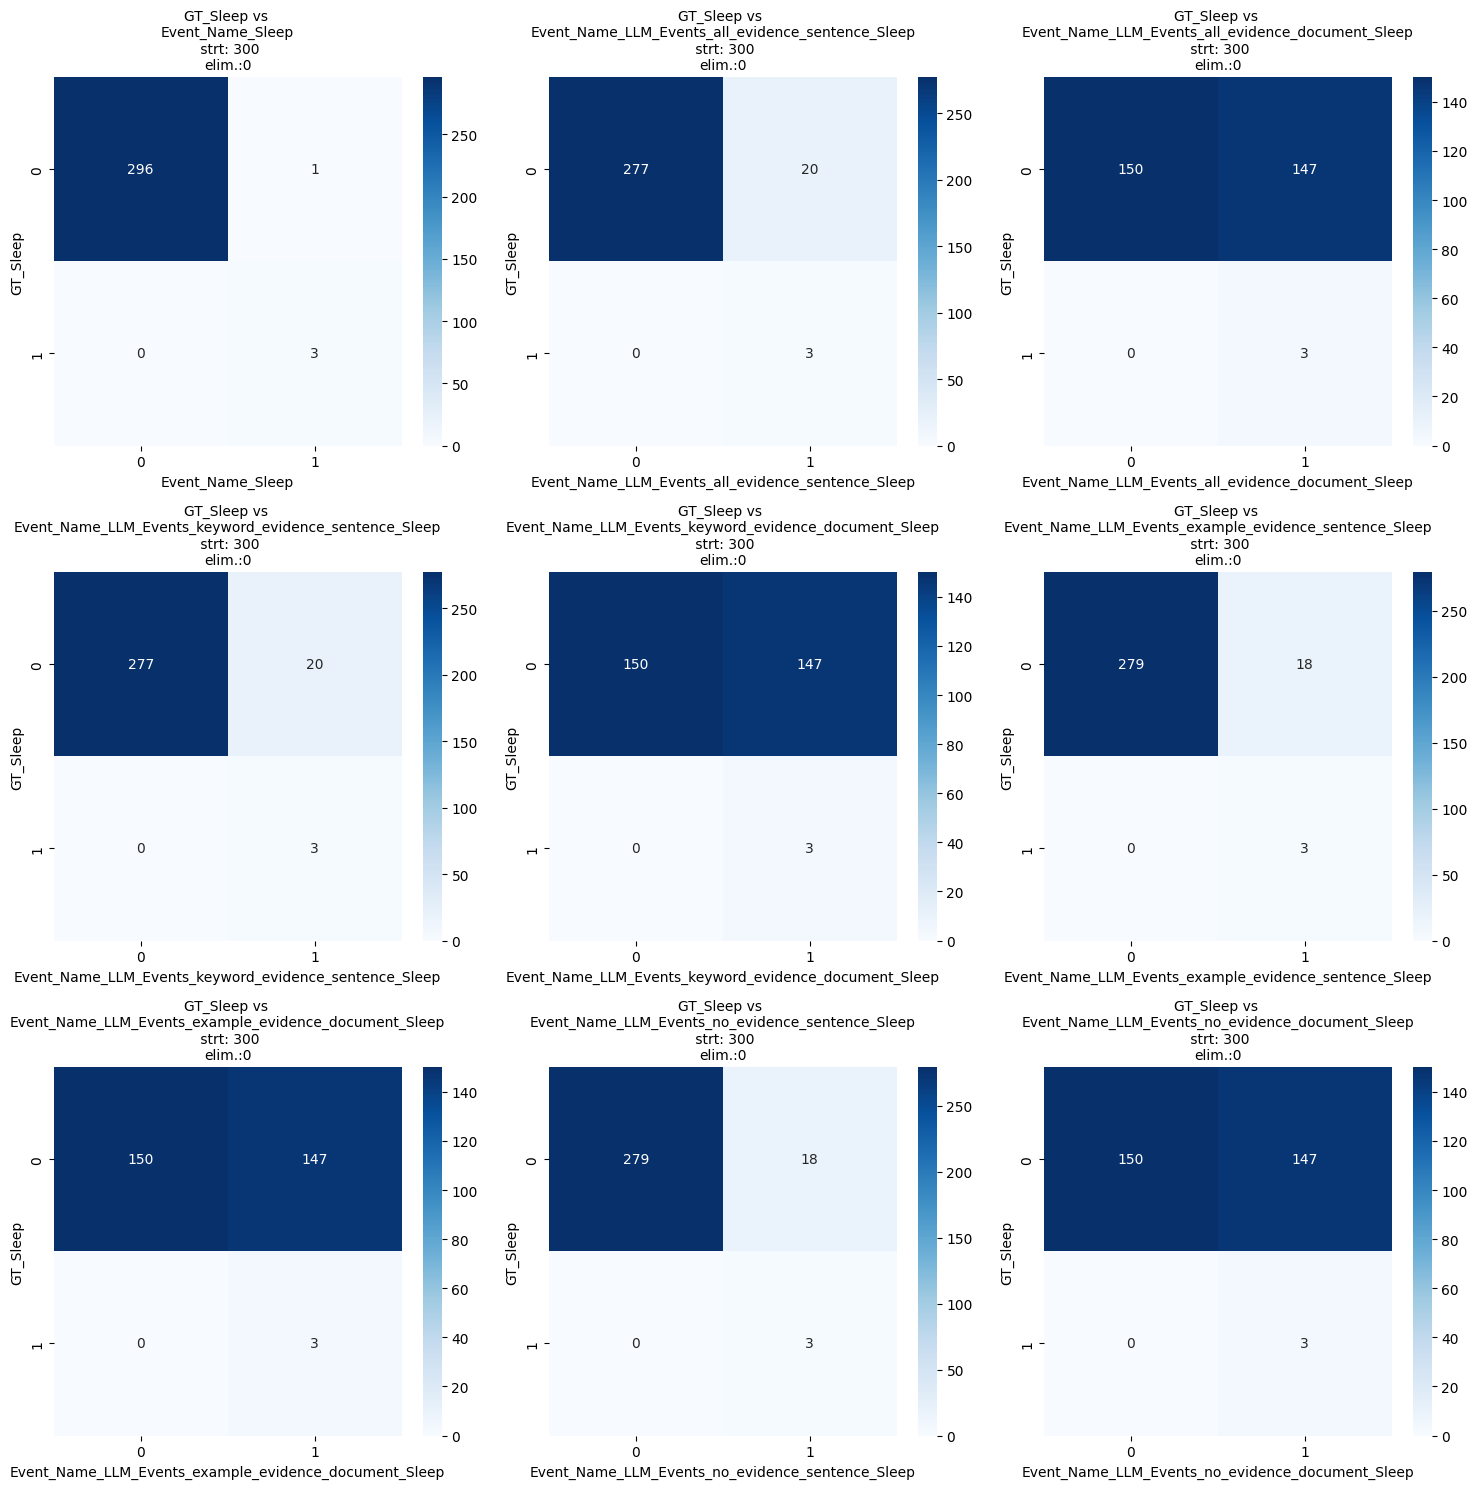

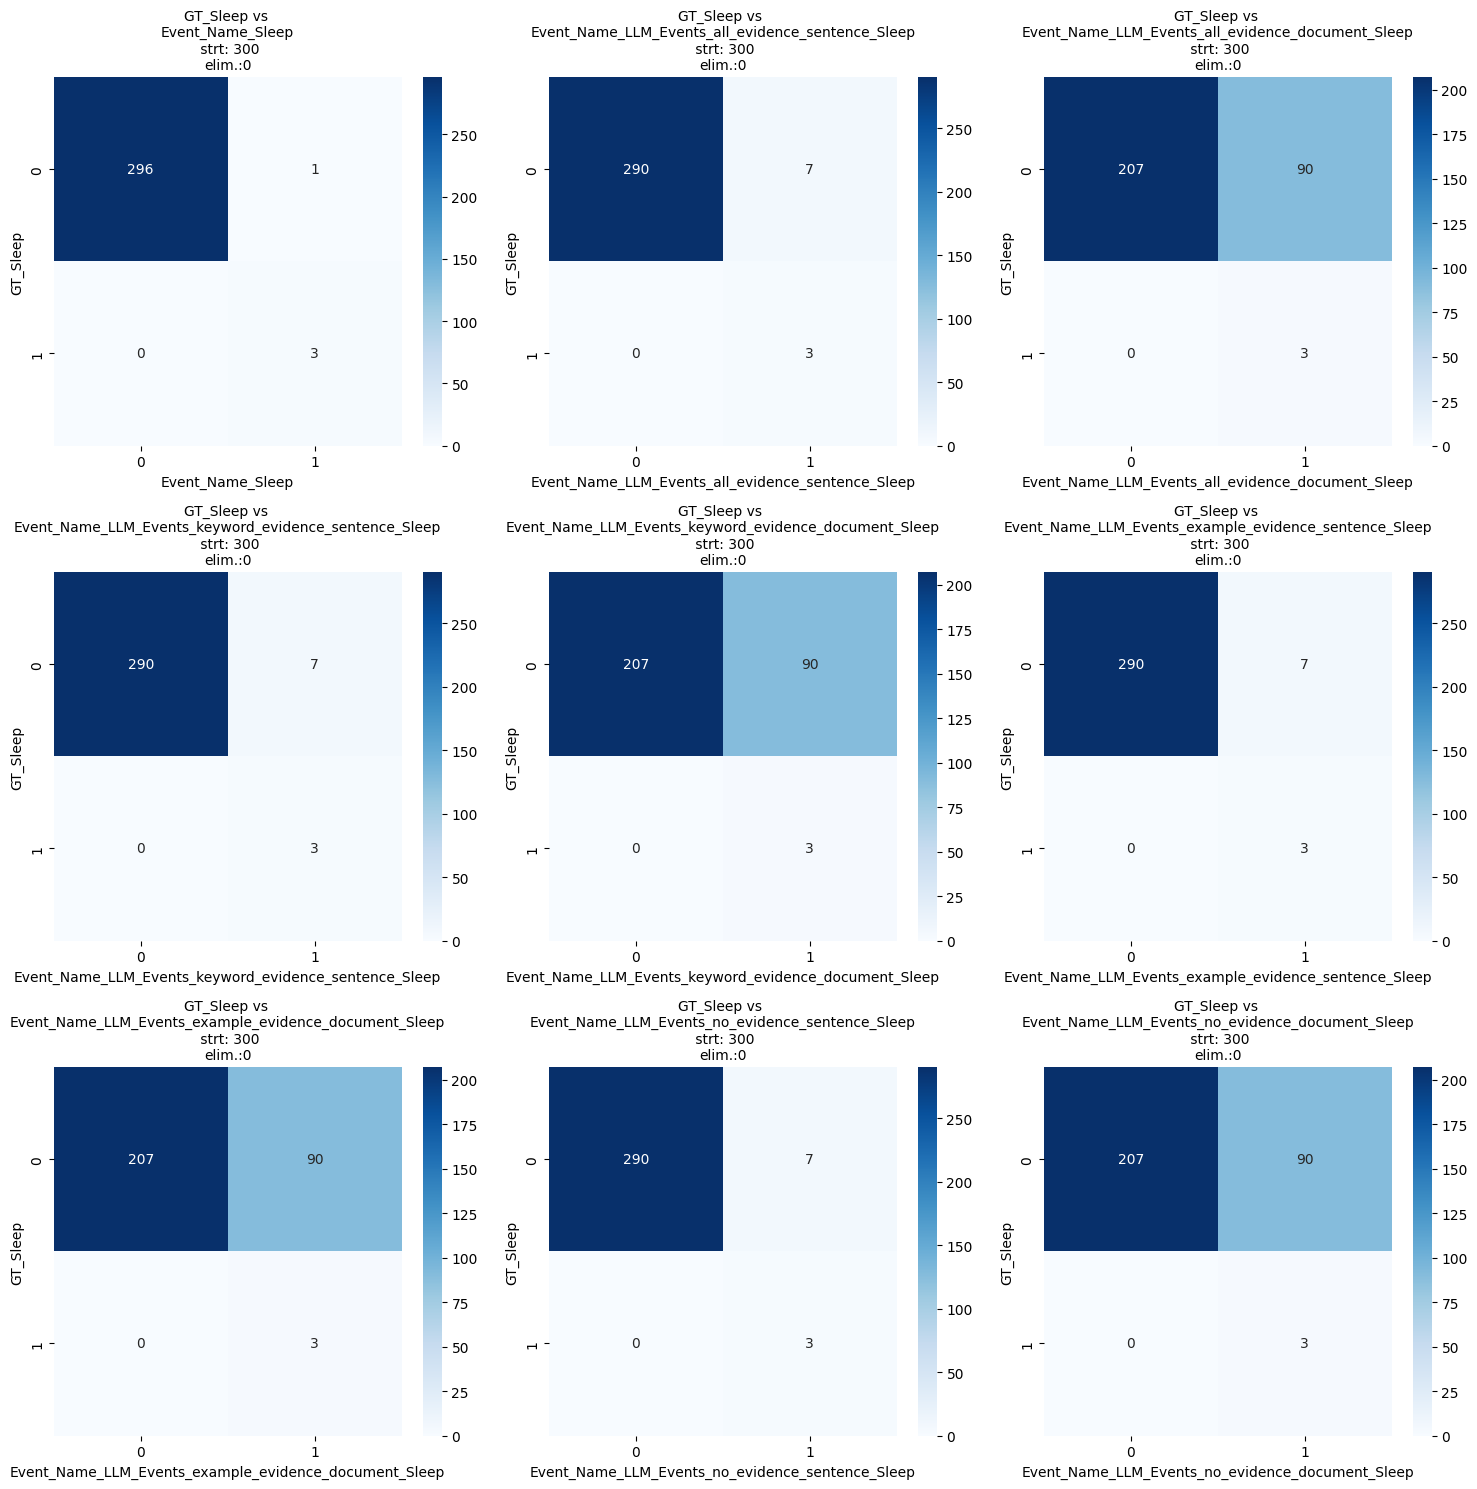

In [24]:
from glob import glob
import os
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from itertools import product
disagreement_type = "correct"
def get_time(x):
    x = np.array(x)
    # Remove NaNs
    x = x[~np.isnan(x)]
    # If less than 3 values, just return mean
    if len(x) < 3:
        return np.mean(x)
    # Remove outliers using IQR
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    mask = (x >= q1 - 1.5 * iqr) & (x <= q3 + 1.5 * iqr)
    return np.mean(x[mask])

def get_event(x):
    global event_types
    if x["event"] != "Unknown":
        return x["event"]
    x = x.copy()  
    try:
        raw = x.get("raw_output", "")
        if isinstance(raw, str):
            parsed = json.loads(raw)
            fields = parsed.keys()
            common_to_labels = set(fields).intersection(set(event_types+["Unknown"])) 
            if "event_type" in fields:
                x["event"] = parsed.get("event_type")
            elif "event type" in fields:
                x["event"] = parsed.get("event type")
            elif len(common_to_labels) > 0:
                x["event"] = list(common_to_labels)
            else:
                x["event"] = "Unknown"
        else:
            x["event"] = "Unknown"
    except (json.JSONDecodeError, TypeError):
        x["event"] = "Unknown"
    return x["event"]

def fixnames(ls,suffix,remove):
    LS=[]
    for s in ls:
        s = s.replace("_keyword_evidence","_Ki").replace("_example_evidence","_Ei").replace("_no_evidence","").replace("_all_evidence","KiEi").replace("Event_Name_",'').replace("_Events",'_').replace('_'+remove,"")
        s = s + "_" + suffix
        if "sentence" in s:
            s = s.replace("sentence","")
            s = s + "_Sent-SET"
        elif "document" in s:
            s = s.replace("document","")
            s = s + "_Doc-SET"
        LS.append(s)
    return LS

def get_col_suffix(keyword_input, example_input):
    col_suffix = "no"
    if keyword_input and example_input:
        col_suffix = "all"
    elif keyword_input and not example_input:
        col_suffix = "keyword"
    elif not keyword_input and example_input:
        col_suffix = "example"
    return col_suffix

def get_keyword(x, event_type):
    x = x.copy()  # avoid modifying original
    try:
        raw = x.get("raw_output", "")
        if isinstance(raw, str):
            parsed = json.loads(raw)
            fields = parsed.keys()
            common_to_labels = set(fields).intersection(set(["Unknown", "Eating", "Sleep", "Excretion", "Family", "Pain"])) 
            if "keyword" in fields:
                x["keyword"] = parsed.get("keyword")
                if type(x["keyword"]) == dict:
                    if event_type in x["keyword"]:
                        x["keyword"] = x["keyword"][event_type]
                    else:
                        x["keyword"] = "Unknown"
            elif "keywords" in fields:
                x["keyword"] = parsed.get("keywords")
                if type(x["keyword"]) == dict:
                    if event_type in x["keyword"]:
                        x["keyword"] = x["keyword"][event_type]
                    else:
                        x["keyword"] = "Unknown"
            elif event_type in fields:
                x["keyword"] = parsed.get(event_type)
            else:
                x["keyword"] = "Unknown"
        else:
            x["keyword"] = "Unknown"
    except (json.JSONDecodeError, TypeError):
        x["keyword"] = "Unknown"
    return x["keyword"]

LLM_dict = {}
llm_models = []
for keyword_input, example_input in [i for i in product([True,False],[True,False])]: 
    for input_type in ["sentence", "document"]:
        col_suffix = get_col_suffix(keyword_input, example_input)
        llm_models.append(f"LLM_Events_{col_suffix}_evidence_{input_type}")
df_both = pd.read_pickle("../exports/04_dictionary_biolord_features.pkl")


for analysis_type in ["all"]: #(M-SET, A-SET, D-SET, F-SET)
    for ET in ["Sleep","Excretion"]:
        print(f"********************{ET}************************")
        llm_files = glob(f"../exports/05_llm_{llm_type}_{dataset}/{ET}/*.pkl")
        try:
            gt_file = glob(f"../exports/04_groundtruth/{dataset}/Annotated/{ET}*.pkl")[0]
        except IndexError:
            print(f"No ground truth file found for {ET} in ../exports/04_groundtruth/{dataset}/Annotated/")
            continue    
        gt_df = pd.read_pickle(gt_file)
        gt_df = gt_df.dropna(subset=f"gt_{ET}")
        gt_df['Lemma'] = gt_df['Lemma'].apply(lambda x: tuple(x))
        gt_df["is_keyword_present"] = gt_df["Keyword"].apply(lambda x: 0 if x[0]=='' else 1)
        
        gt_df = gt_df.groupby("UID")[[ f"gt_{ET}", "is_keyword_present", "Sentence","Lemma","HADM_ID"]].agg(lambda x: max(x) if len(set(x))>1 else set(x).pop()).reset_index()
        uid_to_gt = {row['UID']:row[f"gt_{ET}"] for _,row in gt_df.iterrows()}
        uid_to_key_present = {row['UID']:row[f"is_keyword_present"] for _,row in gt_df.iterrows()}
        uid_to_lemma = {row['UID']:row[f"Lemma"] for _,row in gt_df.iterrows()}
        uid_to_hadmid = {row['UID']:row[f"HADM_ID"] for _,row in gt_df.iterrows()}
        uid_to_dict_time = {row['UID']:row[f"Time"] for _,row in df_both.iterrows()}
        output_folder = f"../exports/disagreements/{ET}"
        os.makedirs(output_folder,exist_ok=True)
        for file in llm_files:
            filename = os.path.basename(file).rstrip('.pkl')
            print(filename)
            _,attribute_requested = filename.split("_")[-2:]
            attribute_requested = eval(attribute_requested)
            
            suffix = "Ao" if attribute_requested else "" 
            
            
            print(suffix,attribute_requested,filename)
            
            df = pd.read_pickle(file)
            df[f'{ET}_time'] = df["UID"].apply(lambda x:uid_to_dict_time.get(x))
            df["focus_event"] = ET
            df[f"GT_{ET}"] = df["UID"].apply(lambda x:uid_to_gt.get(x))
            
            df[f"is_keyword_present"] = df["UID"].apply(lambda x:uid_to_key_present.get(x))
            display(df.is_keyword_present.value_counts())
            
            print(df[[f"GT_{ET}","is_keyword_present"]].value_counts())
                        
            df[f"dict_Lemma"] = df["UID"].apply(lambda x:uid_to_lemma.get(x))
            df[f"HADM_ID"] = df["UID"].apply(lambda x:uid_to_lemma.get(x))
            df.dropna(subset=f"GT_{ET}",inplace=True)
            df[f"GT_{ET}"] = df[f"GT_{ET}"].astype(int)
            df[f"document_GT_{ET}"] = df["ROW_ID"].map(df.groupby("ROW_ID")[f"GT_Sleep"].max().to_dict())
            # df[f"GT_doc_{ET}"] = df.groupby("ROW_ID")[f"GT_{ET}"].transform(max)
            for col in llm_models:
                df[f"{col}_{ET}_time"] = df[col].apply(lambda x:x['event_detection_time'])
            if len(df) > 1:
                first_row = df.iloc[0]
                splittable_columns = ["Event_Name"]+[f"Event_Name_{model}" for model in llm_models]
                disagreement_dfs = []
                generated_columns = []

                for col in splittable_columns:
                    generated_column = f"{col}_{ET}"
                    df[generated_column] = df[col].apply(lambda x: 1 if ET in x else 0)
                    
                    generated_columns.append(generated_column)
                
                f1s, accs, precs, recs, psup, nsup, times, tp, tn, fp, fn = [],[],[],[],[],[],[],[],[],[],[]
                
                
                for col in generated_columns:
                    if "sentence" in col:
                        df_temp = df.groupby("ROW_ID").agg({f"GT_{ET}":"max", col:"max", f"{col.lstrip('Event_Name_')}_time":"mean", "HADM_ID":"first", "UID":"first"}).reset_index()
                        y_gt = df_temp[f"GT_{ET}"]
                    elif "document" in col:
                        df_temp = df.groupby("ROW_ID").agg({f"GT_{ET}":"max", col:"first", f"{col.lstrip('Event_Name_')}_time":"max", "HADM_ID":"first", "UID":"first"}).reset_index()
                        y_gt = df_temp[f"GT_{ET}"]
                    else:
                        df_temp = df.groupby("ROW_ID").agg({f"GT_{ET}":"max", col:"max", f"{col.lstrip('Event_Name_')}_time":"mean", "HADM_ID":"first", "UID":"first"}).reset_index()
                        y_gt = df_temp[f"GT_{ET}"]
                    LLM_dict[(attribute_requested,f"gt_{ET}")] = y_gt
                    preds = df_temp[col]
                    LLM_dict[(attribute_requested,col)] = preds
                    f1s.append(f1_score(y_gt, preds))
                    accs.append(accuracy_score(y_gt, preds))
                    precs.append(precision_score(y_gt, preds, zero_division=0))
                    recs.append(recall_score(y_gt, preds))   
                    psup.append(sum(y_gt))
                    nsup.append(sum(y_gt==0))
                    times.append(get_time(df_temp[f"{col.lstrip('Event_Name_')}_time"]))
                    #true positive
                    tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_gt, preds).ravel()
                    tp.append(tp_i)
                    tn.append(tn_i)
                    fp.append(fp_i)
                    fn.append(fn_i)
                
            
                results_df = {"col_name":generated_columns, "technique":fixnames(generated_columns,suffix,ET), "pos_sup": psup, "neg_sup": nsup, "f1_score":f1s, "precision":precs, "recall":recs, "TP":tp, 'TN':tn, 'FP':fp, 'FN':fn, "time":times} 
                results = pd.DataFrame(results_df)   
                plot_confusion_matrices_for_column_pairs(df, f"GT_{ET}",vis_columns=generated_columns)
                op_path = f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx"


                df.to_excel(op_path,index=False)
                print(f"file written to {op_path}")
                display(results)

In [16]:
col

'Event_Name_Sleep'

{1277038: 0,
 1277048: 1,
 1277049: 0,
 1277050: 0,
 1277051: 1,
 1277052: 0,
 1277053: 0,
 1277054: 0,
 1277055: 0,
 1277056: 0,
 1277057: 0,
 1277058: 0,
 1277059: 0,
 1277060: 1,
 1277061: 0,
 1277062: 0}

In [4]:
df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'DOCUMENT',
       'AGE', 'LOS_DAYS', 'IS_ALIVE', 'DOCUMENT_LOWER', 'NUM_NOTES',
       'MAX_NOTES_PER_DAY', 'MAX_NOTES_PER_CHARTTIME', 'all_dates_present',
       'Sentences', 'Sentences_Raw', 'Sentences_Cleaned', 'Events', 'Sent_ID',
       'UID', 'Event_Name', 'Sentence', 'Time', 'Keyword', 'Lemma',
       'Keyword_Position', 'LLM_Events_all_evidence_sentence',
       'Event_Name_LLM_Events_all_evidence_sentence',
       'Attribute_LLM_Events_all_evidence_sentence',
       'LLM_Events_keyword_evidence_sentence',
       'Event_Name_LLM_Events_keyword_evidence_sentence',
       'Attribute_LLM_Events_keyword_evidence_sentence',
       'LLM_Events_example_evidence_sentence',
       'Event_Name_LLM_Events_example_evidence_sentence',
       'Attribute_LLM_Events_example_evidence_sentence',
       'LLM_Events_no_evidence_sentence',
       'Event_Name_LLM_Eve

In [5]:
df[["DOCUMENT","Event_Name_LLM_Events_keyword_evidence_document_Ao","Sentence" ,"GT_Sleep"]].to_excel("../exports/temp_result.xlsx",index=False)

KeyError: "['Event_Name_LLM_Events_keyword_evidence_document_Ao'] not in index"

In [ ]:
'dictionary_Sleep_time' in df.columns, llm_models

(False,
 ['LLM_Events_all_evidence_sentence',
  'LLM_Events_all_evidence_document',
  'LLM_Events_keyword_evidence_sentence',
  'LLM_Events_keyword_evidence_document',
  'LLM_Events_example_evidence_sentence',
  'LLM_Events_example_evidence_document',
  'LLM_Events_no_evidence_sentence',
  'LLM_Events_no_evidence_document'])

In [ ]:
y_gt.value_counts()

GT_Sleep
0    297
1      3
Name: count, dtype: int64

In [ ]:
gt_df = pd.read_pickle(gt_file)
gt_df = gt_df.dropna(subset=f"gt_{ET}")
gt_df["Keyword"],gt_df["Keyword"].apply(lambda x: 0 if x[0]=='' else 1).value_counts()


KeyError: ['gt_Excretion']

In [ ]:
gt_df.Keyword.value_counts()

In [ ]:
df_dictionary = pd.read_pickle(f"../exports/03_selected_reports_with_event_log_only_dictionary_v2/combined.pkl")

In [ ]:
df_dictionary['Events'].iloc[0]

In [ ]:
import pandas as pd
from glob import glob
ET = "Sleep"
df = pd.read_pickle(glob(f"../exports/04_groundtruth/P-SET/Generated/{ET}*.pkl")[0])
print(df.UID.nunique(), df.Sentence.nunique(), df.ROW_ID.nunique(), df.SUBJECT_ID.nunique(), df.Event_Name.value_counts())

df_exploded = df.explode(['Keyword','Lemma','Event_Name','Keyword_Position'])
df_exploded['KUID'] = df_exploded['UID'] + "_" + df_exploded['Keyword_Position'].astype(str)
print(df_exploded.Event_Name.value_counts(),df_exploded[df_exploded.Event_Name==ET]['Lemma'].value_counts())

# df[['SUBJECT_ID', 'LOS_DAYS', 'AGE']].drop_duplicates().mean()




4783 4435 210 10 Event_Name
[Unknown]                                  4311
[Sleep]                                     114
[Pain]                                      112
[Family]                                    101
[Excretion]                                  66
[Eating]                                     21
[Sleep, Sleep]                               16
[Pain, Pain]                                 16
[Pain, Sleep]                                 7
[Family, Sleep]                               4
[Eating, Eating]                              3
[Family, Pain]                                2
[Family, Family]                              2
[Family, Family, Family, Family]              1
[Family, Pain, Sleep, Sleep]                  1
[Sleep, Sleep, Sleep]                         1
[Eating, Family, Sleep]                       1
[Excretion, Excretion]                        1
[Family, Family, Family, Family, Sleep]       1
[Family, Family, Family]                      1
[Pain, Pain,

In [ ]:
df_exploded[df_exploded.Event_Name=="Sleep"].to_excel("../exports/temp_sleep_keywords.xlsx")

In [ ]:
top10_patients = df_exploded[df_exploded.Event_Name=="Sleep"].SUBJECT_ID.unique().tolist()

In [ ]:
df[df.SUBJECT_ID.isin(top10_patients)].to_excel("../exports/temp_top10_patients_all_events.xlsx")